# Resilience Statistics for Soft Faults
We run experiments on how well the resilience strategies are able to correct soft faults by manually flipping bits and checking if they are recovered.
Let's introduce all the concepts with the [Van der Pol](https://github.com/Parallel-in-Time/pySDC/blob/master/pySDC/implementations/problem_classes/Van_der_Pol_implicit.py) equation.
To keep this notebook tidy, I wrote a class that contains functions for generating and processing statistics, which we first need to set up. Don't worry about the parameters for now, we will explain them as we go along.

## TODO
 - Fix accuracy section
 - Fix conclusion
 - Proofread everything

In [1]:
from fault_stats import FaultStats, BaseStrategy, AdaptivityStrategy, IterateStrategy, HotRodStrategy, run_vdp
import matplotlib.pyplot as plt
import numpy as np
import pySDC.helpers.plot_helper as plot_helper
plot_helper.setup_mpl(14, True)
plot_helper.mpl.rcParams['figure.dpi'] = 300

vdp_stats = FaultStats(prob=run_vdp, faults=[False, True], reload=True, recovery_thresh=1.5, num_procs=1,
                       strategies=[BaseStrategy(), AdaptivityStrategy(), IterateStrategy(), HotRodStrategy()])

vdp_stats.run_stats_generation(runs=5000, step=50)

## How do we insert faults?
We randomize the process quite a bit, but we want to put the same faults in all strategies, so we have to compromise a little.
For each problem, we pick a time where something happens so that the potential impact of the faults is big and we put faults in at the same time in the simulation in every run.
What we randomize is the bit, the collocation node, the iteration, and the problem position at which we put in the faults.
However, we give a fixed range of iterations in which the faults can occur to make sure the strategies face the same faults.

Since we put in only single faults here, we neglect that the cheaper the simulation is, the more resilient it is, because probability of a fault scales with the physical size of the system that we use and with the time that we run on it.
This is a direct consequence of Murphy's law, which states that the probability of a failiure is proportional to the number of opportunities for a failiure.
If you take a bike ride from Jülich to Cologne, you will probably be fine, but if $10^6$ people ride their bikes from Jülich to Vienna, the probability that one of them will fall over is extremely high.

## What resilience strategies do we look at?
We test the following strategies:
 - base: Fixed iteration count and fixed step size
 - adaptivity: Fixed iteration count and adaptive step size
 - iterate: Adaptive iteration count and fixed step size
 - Hot Rod: Fixed everything, but detector on top

What sort of resilience do we expect from these strategies?

### Base scheme
Well, the base scheme does nothing to prevent faults, but a lot of faults don't really impact the solution and some have no impact at all.
When using a set of quadrature nodes, where the right node corresponds to the interface, for instance, all faults occuring in the last iteration in any but the interface node do not impact the solution, which is
$$
\frac{1}{N_\mathrm{iter}}\times\frac{N_\mathrm{coll}-1}{N_\mathrm{coll}} = \frac{1}{3}\times\frac{3}{4}= 25\,\%
$$
in our van der Pol example, so actually quite a significant amount!

Also, we solve the problem only to limited precision and perturbing the solution below this precision has no impact on the outcome as well.
We use `numpy.ndarray` to store the solution, which stores the individual floating point numbers in a 64 bit format by default.
The error of the fault-free runs, which we compute with a scipy reference solution, is on the order of $10^{-6}$ and the precison of the double implementation goes down to about $10^{-11}$, so you can imagine that there are many bits which change the solution by less than we care about.

### Adaptivity
This scheme will restart the current step whenever an estimated error exceeds some predefined tolerance.
See [this notebook](https://github.com/Parallel-in-Time/pySDC/blob/master/pySDC/projects/Resilience/Adaptivity.ipynb) for details.
The tolerance is either not reached because the step size was too large, or because a fault occurred, both cases will lead to a restart of the step with a refined step size.
Don't worry!
The step size is increased again if we over-resolved the problem, which is the case for fault triggered refinement.

### Iterate
Here, we just set a residual tolerance and iterate until we reach it or until we reach 99 iterations, at which point we get impatient and move on no matter the state of the solution.
This works well in fixing smaller faults, but it does struggle a bit with larger faults.
A potentially more efficient strategy would be to restart if the residual threshold was not reached after a maximum amount of iterations.


### Hot Rod
[Hot Rod](https://doi.org/10.1007/978-3-319-43659-3_47) is a detector for soft faults that was developed in the context of explicit Runge-Kutta methods, but as they mention in the paper, it can easily be implemented in other methods as well.
See [this notebook](https://github.com/Parallel-in-Time/pySDC/blob/master/pySDC/projects/Resilience/HotRod.ipynb) for some explanations. 

### Faults we cannot fix
We have a large problem when the fault hits the initial conditions of a step, a.k.a. collocation node zero in the implementation in pySDC.
We may still converge to the solution of some problem, but it's not the problem we set out to solve!
In our example, this corresponds to
$$
\frac{1}{N_\mathrm{coll}}=\frac{1}{4} = 25\,\%
$$
of faults.
You might find some solace in that not all of them are actually bad.
If you have a fixed iteration count, such faults occuring in the last iteration fall under the no-impact category discussed in the base scheme, so for a fixed iteration scheme, we get only
$$
\frac{1}{N_\mathrm{coll}}\times\frac{N_\mathrm{iter}-1}{N_\mathrm{iter}}=\frac{1}{4} \times \frac{2}{3} \approx 16\,\%
$$
uncorrectable faults.
Additionally, quite a bit (in our case about half) are insignificant because they hit mantissa bits that we don't care about.

### How do the strategies compare without faults?
<a id='efficiency'></a>
The strategies mess with the overall scheme quite a bit so we want to make sure we solve the problem to similar accuracy and we want to know what the computational cost is for each scheme to reach this accuracy.
The two quantities that we look at are the local error $\epsilon$ and iteration counts.

We compute the local error with `scipy.solve_ivp`, where we solve the problem for a single time step to very low tolerances to approximate the true solution.
We have to do this because no analytic solution is available for the van der Pol equation, but we convinced ourselves in the [Hot Rod notebook](https://github.com/Parallel-in-Time/pySDC/blob/master/pySDC/projects/Resilience/HotRod.ipynb#order) that this works well enough.

As a unit for the computional cost, we use the iteration count since the iterations are the most expensive part of the computation.
Actually, we make a simplification here, because we do not look at the Newton iterations, but at the SDC iterations, meaning we assume the cost of an SDC sweep to be constant, while it does not have to be.

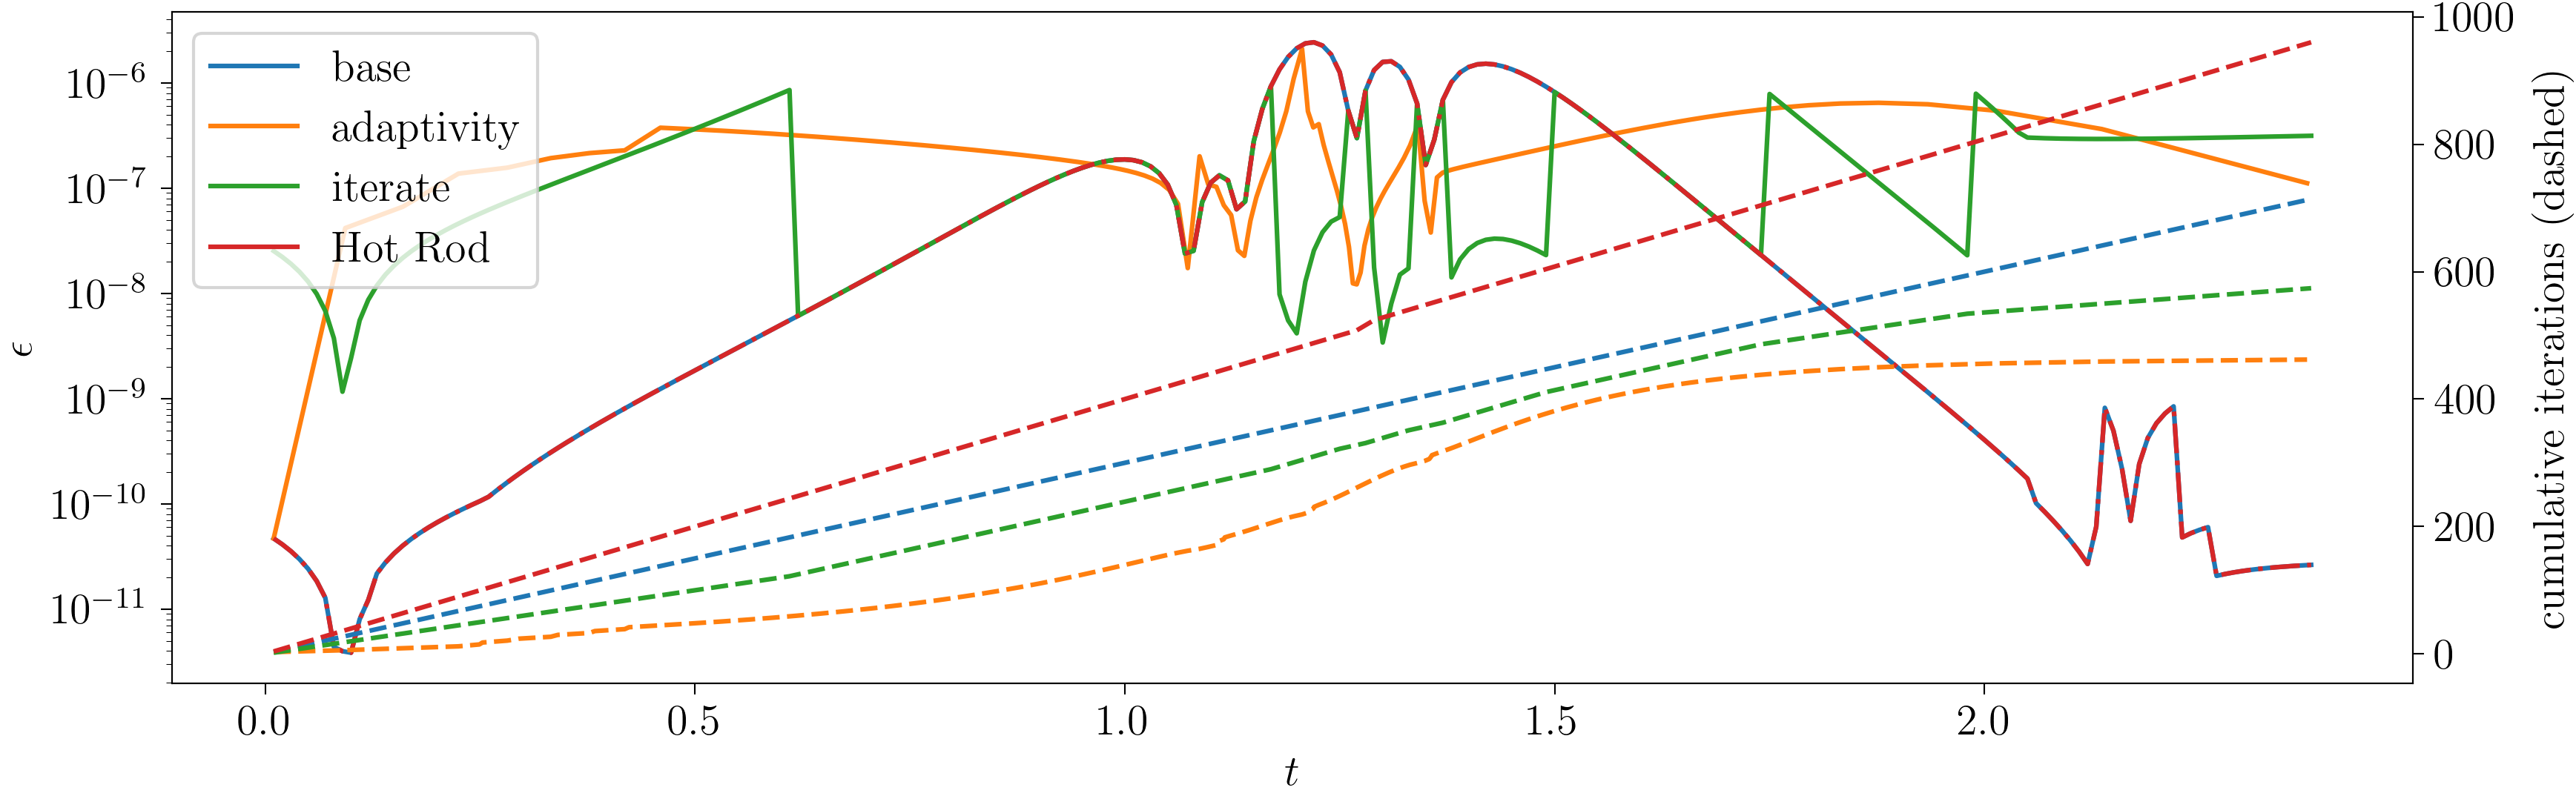

In [2]:
fig, ax = plt.subplots(1,1, figsize=(13, 4))
vdp_stats.compare_strategies(ax=ax)

#### What accuracy do the schemes have?
The time scale of the problem has three phases: Initially, the oscillation is slow, then it is fast and then it slows down again.
If we solve the problem with the same parameters throughout, we are going to get very high accuracy in the beginning and end to get the accuracy we need in the middle.
Of course that does not get us anything useful.
We can only control the local error here and if our initial conditions carry a significant global error, there is no use in having a really small local error.

So what we should look at instead is the local error in the middle, when the oscillation is fast, since that has the largest impact on the global error.
In the above plot, you can see there are four orders of magnitude between the local errors for the base scheme in the middle and beginning!



This plot is a bit of a mess, but there are a few intersting details that can be read off from here.
On the left y-axis, you can find the embedded error estimate, which is simply the norm of the difference of the solutions of to consecutive iterations and it's a good approximation for the local error of the second to last iteration.
That means we only expect it to be the same between two methods if they perform the same amount of iterations, which is not the case for all strategies here!

Also, you will see that the local error is equal to machine precision at some times for some strategies.
This is because the solution does not change between two iterations and since we need a non-zero local error for adaptivity, we just set it to `numpy.finfo(float).eps` in that case.
Of course, if the solution does not change between iterations, that means you are doing too many iterations!
And you will see that this only happens for strategies with fixed step size and iteration count, where we decide to over-resolve the periods in time where not much is happening in order to properly resolve the periods where the solution is quickly changing.

The third peculiar looking thing is that the green line stops before the others do.
The green line is for adaptive iteration count and in this area, the residual tolerance is already reached after the first iteration, such that we don't get a chance to compute an embedded estimate where we would need at least two iterations.
In other parts of the plot, the green line jumps between the blue and red lines.
What's happening here?
Well, the blue line is the base scheme with three iterarions and the red one is Hot Rod, which requires us to do one extra iteration but then throw it away.
So while the accuracy of Hot Rod is actually the same as for the base method, the red line shows the embedded error after four iterations.
A jump in the green line can simply be explained as a jump in iterations until the residual tolerance is satisified.

#### How efficient are the schemes?
While this plot is imperfect in many ways, we can see that we are solving the problem to similar accuracy with all schemes in the absense of faults.
Now let's have a brief look at how expensive the schemes are by counting some iterations, which are the most expensive part.

The base and Hot Rod schemes show straight lines in the cumulative iteration plot, which reflects the constant number of iterations in each step.
We can see however, that using Hot Rod adds one extra iteration and keep in mind that we don't actually gain accuracy, we do this only to get an estimate of the full method rather than some similar method of lower order, as we do in adaptivity.

When we are allowed to adapt something during runtime, both iteration number or step size, you can see that we gain performance while increasing accuracy or at least keeping it the same, so this seems like a good idea in general, regardless of whether we have faults or not.

## How to decide whether a fault is recovered?
Unfortunately, there is no natural criterion for recovery of a fault.
What we decided to do is estimate the error at the end of the run and compare it to the error that we would get if no fault had occurred.
Since with some strategies we don't expect this to match exactly, we give some leeway, so we accept if
$$
e \leq \gamma e^*,
$$
where $\gamma \geq 1$ is the acceptance threshold and $e$ and $e^*$ are the errors of the run with faults and without faults respectively.
But what is a good value for $\gamma$?
We can make a plot how this changes the overall recovery rate and decide on a problem-specific basis:

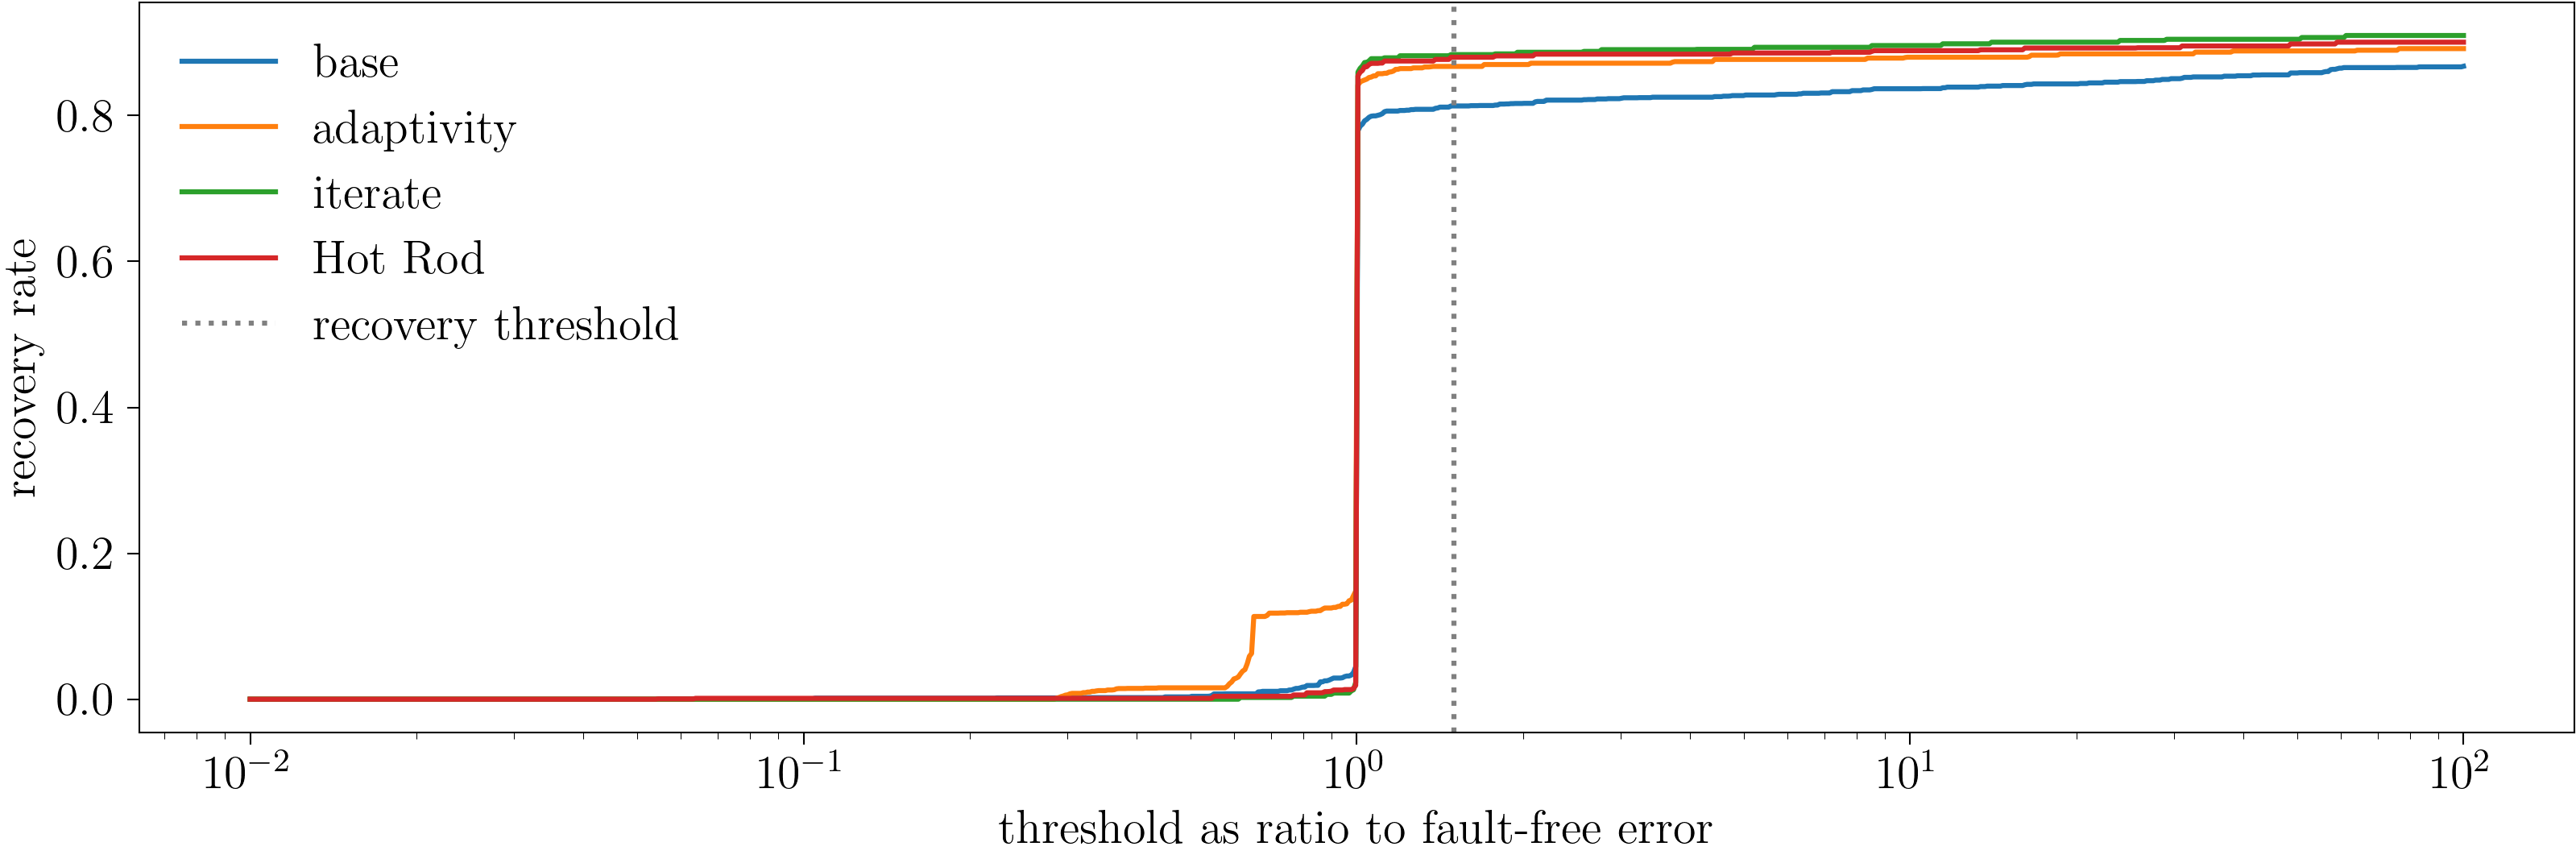

In [3]:
fig, ax = plt.subplots(1,1, figsize=(13, 4))
vdp_stats.plot_recovery_thresholds(ax=ax, thresh_range=np.logspace(-2, 2, 1000))
ax.axvline(vdp_stats.recovery_thresh, color='grey', ls=':', label='recovery threshold')
ax.set_xscale('log')
ax.legend(frameon=False)
plt.show()

You can see that again, there is no obvious value we can read off of this plot, but we decide to be a bit forgiving with adaptivity and choose $\gamma=1.5$ here.
Actually, we already put this in above when we instantiated the `vdp_stats` object, but we "justify" this here.

## Which faults can be recovered?
We can now make some plots of the recovery rate depending on where the faults hit.
But first, let us make sure that we performed a sufficient amount of experiments.

 tot:   5000 | avg. counts | mean deviation | unique entries
-------------------------------------------------------------
 iteration   |      1666.7 |          12.22 |              3
 bit         |        78.1 |           7.45 |             64
 node        |      1250.0 |          27.00 |              4


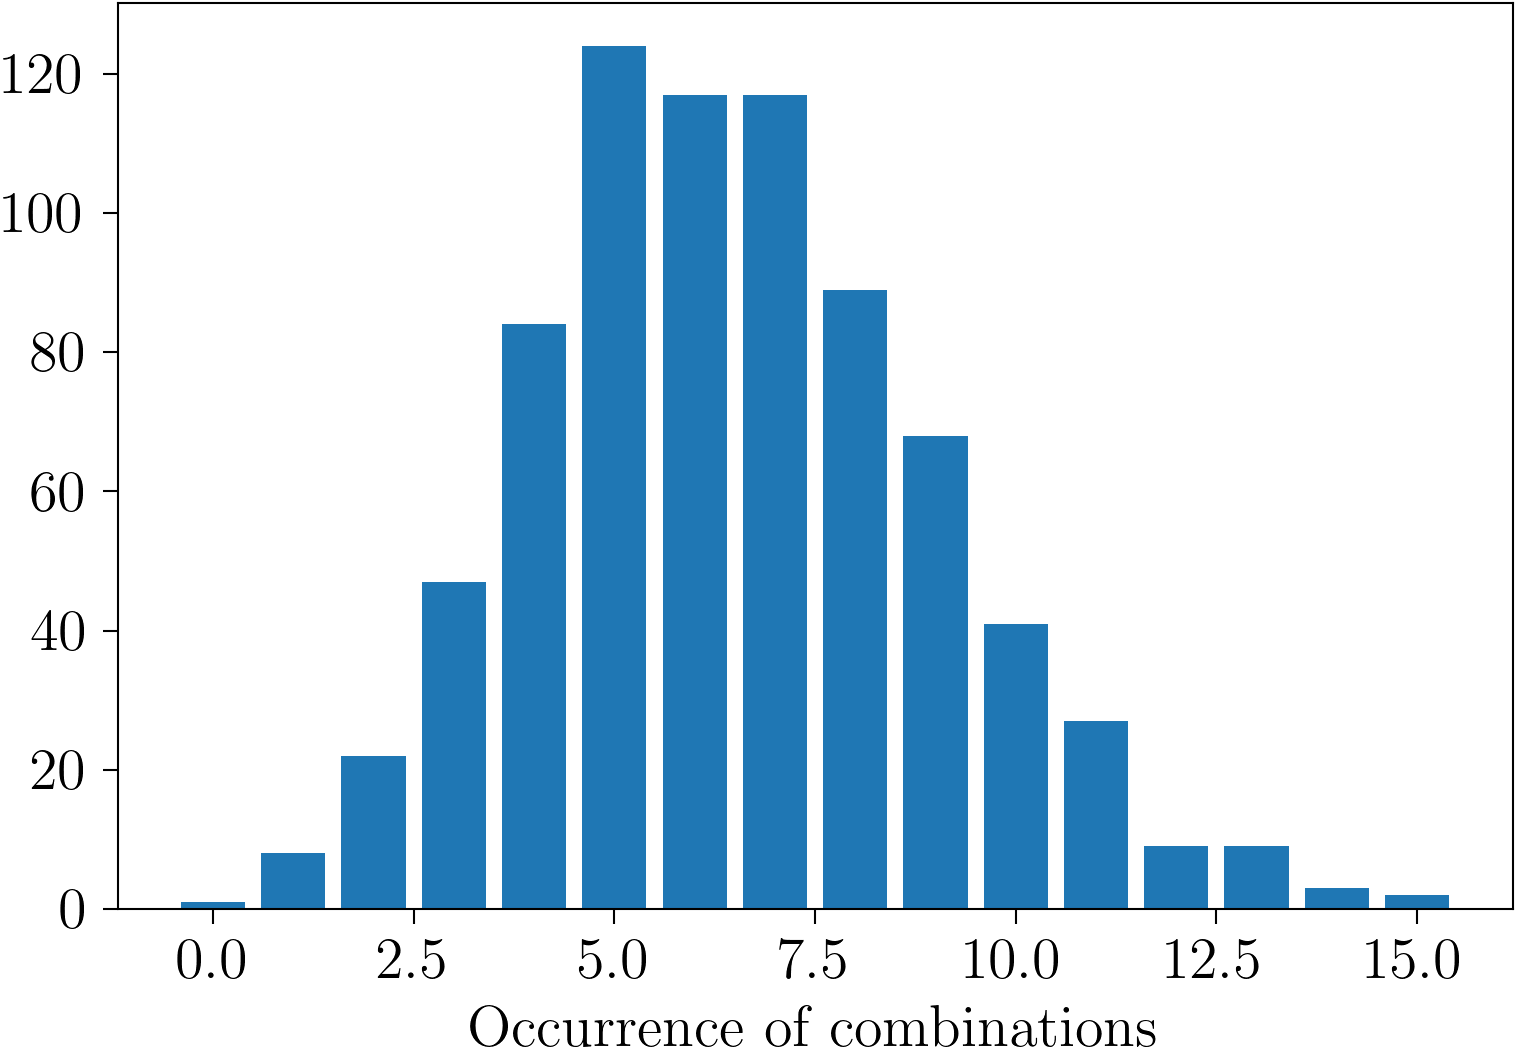

In [4]:
vdp_stats.get_statistics_info()
_ = vdp_stats.combinations_histogram()

The above cell tells us how many experiments we did in total and the most important column is the thrid one, which tells us the average deviation of counts of unique values from the mean.
For instance if we have 64 bits, we should get 64 unique entries in the bit row and would like that they each get hit an equal amount in experiments so the average count should be $N_\mathrm{tot}$ / #unique entries and ideally the mean deviation would be 0.

We also look at a histogram of how often we get every possible combinations of where to put in the fault.
If any are 0, we better make more experiments.

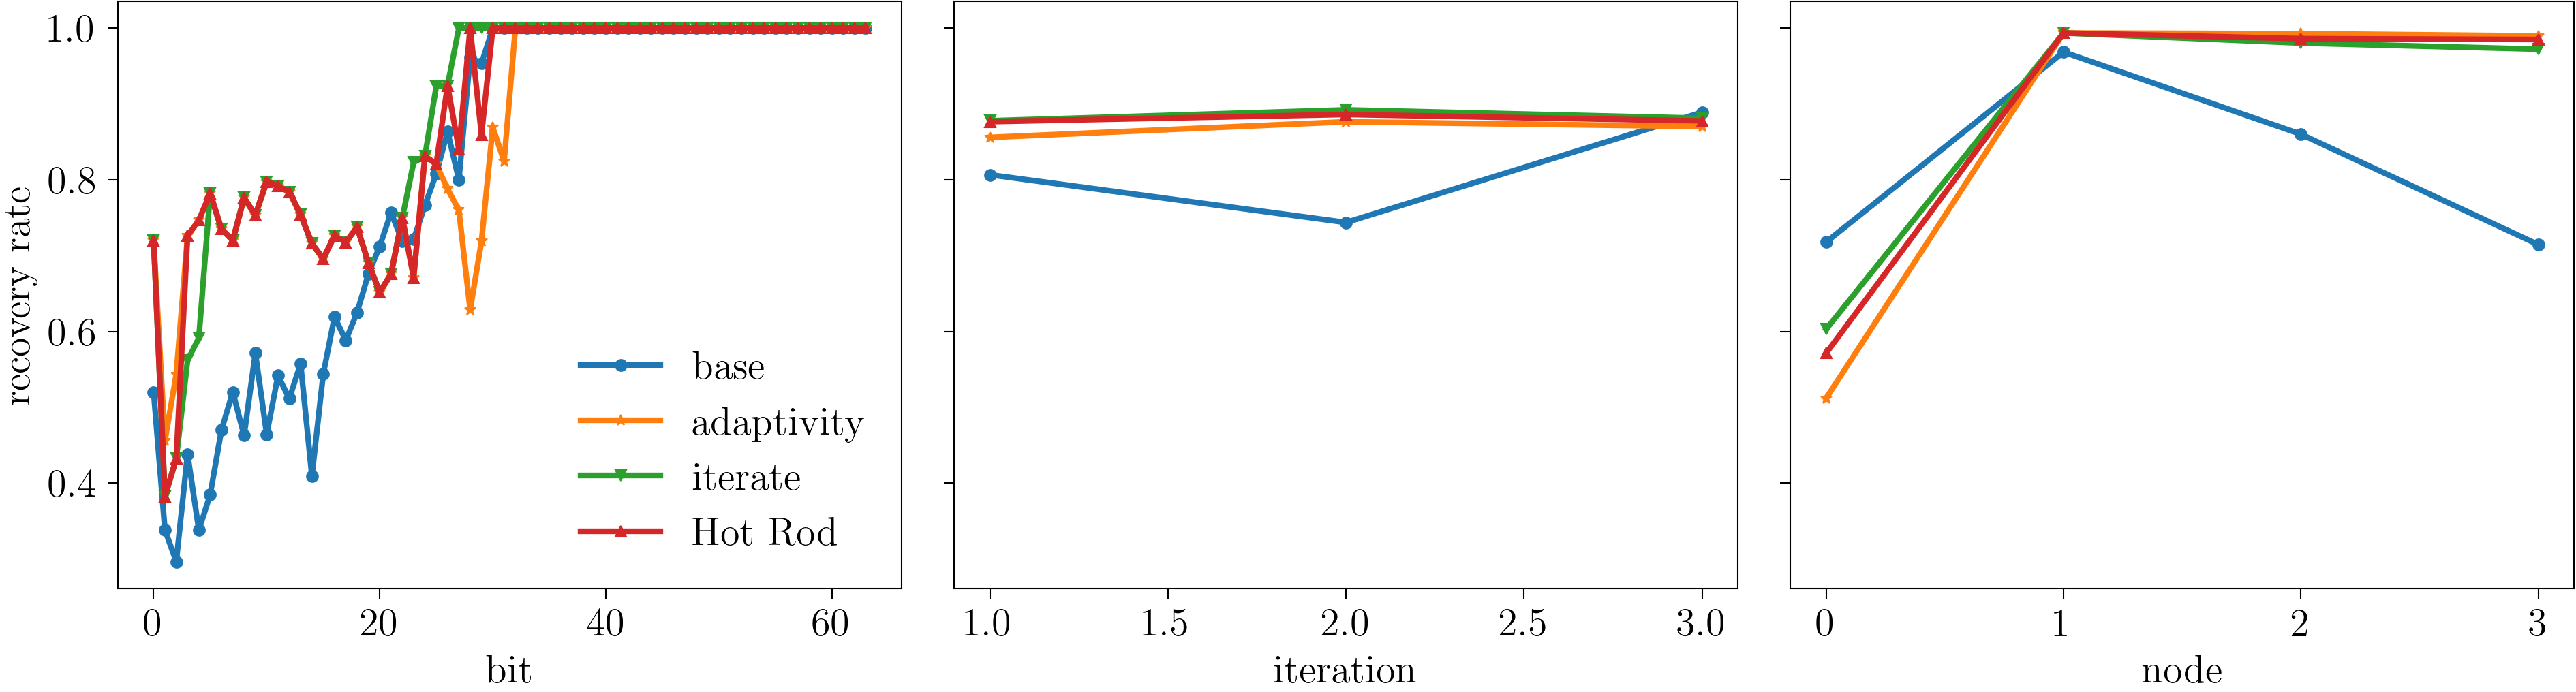

In [5]:
def plot_stuff(stats, op, ylabel, mask, suptitle='', thingA='bit'):
    fig, axs = plt.subplots(1, 3, figsize=(13, 4), sharey=True)
    stats.plot_things_per_things(thingA=thingA, thingB='bit', op=op, args={'ylabel': ylabel}, ax=axs[0], mask=mask)
    stats.plot_things_per_things(thingA=thingA, thingB='iteration', op=op, args={'ylabel': ''}, ax=axs[1], mask=mask)
    stats.plot_things_per_things(thingA=thingA, thingB='node', op=op, args={'ylabel': ''}, ax=axs[2], mask=mask)
    axs[1].get_legend().remove()
    axs[2].get_legend().remove()
    fig.suptitle(suptitle)
    fig.tight_layout()

plot_stuff(vdp_stats, op=vdp_stats.rec_rate, ylabel='recovery rate', mask=None)

In the above plots, we can read off a few things that determine how bad a fault is:
 - Flipping mantissa bits beyond 31 does not impact the simulation
 - We don't really care in what iteration the fault happened
 - "Later" collococation nodes are more likely to cause trouble
 - However, node 0 faults (which actually hit the initial conditions) are the least likely to be recovered

Great!
This is exactly what we expected!
The only slightly odd observation is that we would expect the base strategy to do better with faults to early iterations, but this does not seem to be the case. Maybe we would observe this with increased sample size.

We do, however struggle to identify a clear winner.
The base strategy is worse in terms of resilience, but actually not by that much.
Let's look a bit closer!

One of the major things that people are scared about when it comes to faults is SDC.
Wait, I don't mean spectral deferred corrections, I mean silent data corruption, which shares the acronym by coincidence and we will just write it out from now in this notebook.

So what silent data corruption is, is a fault in your simulations that is not obvious and just flies under the radar, but then the final simulation result will be perturbed and you can never really be sure whether you just simulated some astonishing physics or whether the cosmos was just particularly malevolent to you that day.
Of course you can check by rerunning the simulation because faults a random process from your point of view, but we want to avoid pure replication because it is very expensive.

While aside may help motivate this project, the point we actually want to make here is that there is also the opposite of silent data corruption: Faults that make the code crash.
Since the van der Pol problem is non-linear and we integrate implicitly, we use a Newton solver, which regulaly crashed because of overflow errors.
Let's have a look at what sort of fault leads to a crash:

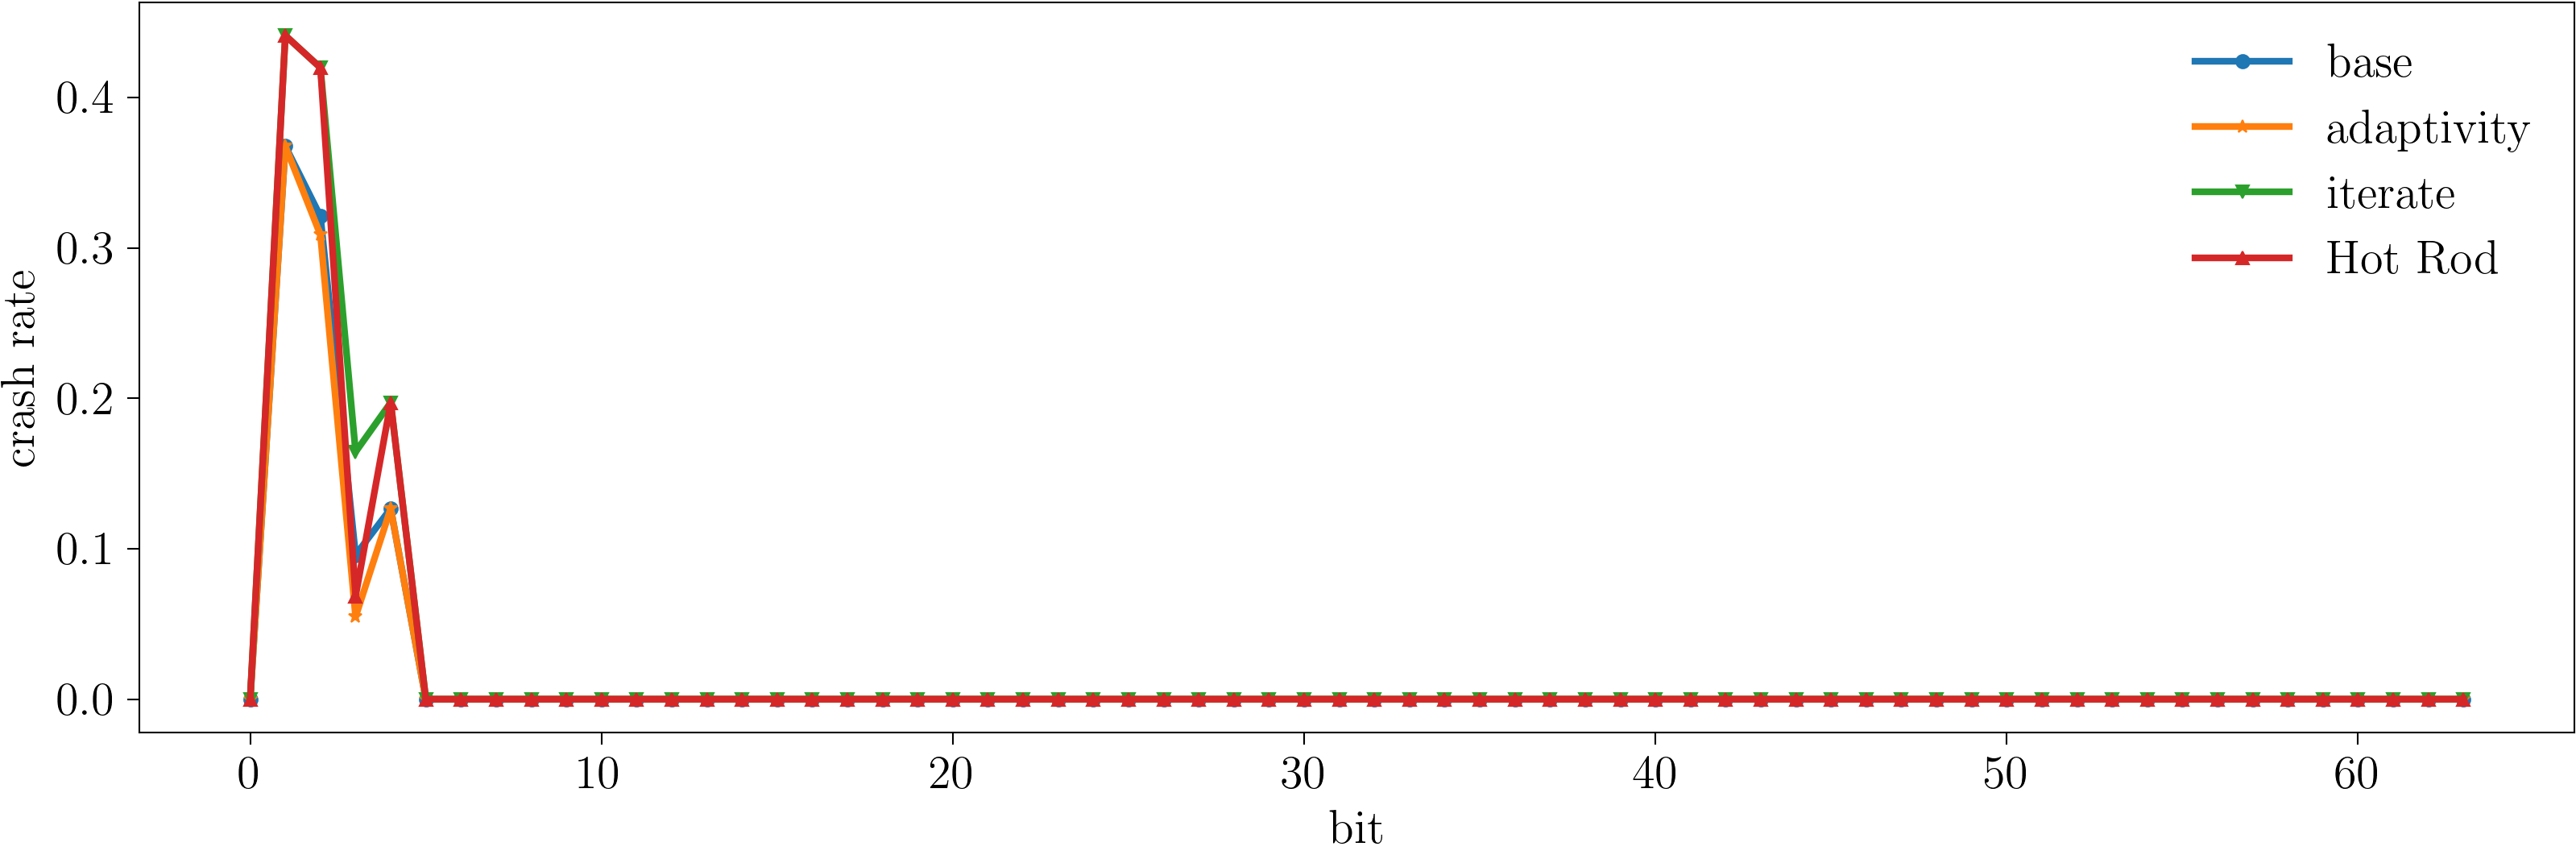

In [6]:
fig, ax = plt.subplots(1,1, figsize=(13, 4))
vdp_stats.plot_things_per_things(thingB='bit', op=vdp_stats.crash_rate, args={'ylabel': 'crash rate'}, ax=ax)

Two things become apparent:
 - The strategies all fail at the same faults because after the code has crashed it's game over
 - The bits that cause the code to crash are all in the exponent with bit 1 being our new arch nemesis

Both of these things are expected of course, but are totally problem specific.
We could easily implement a strategy that restarts the step when the solver has failed instead of crashing the code, but since this is a different and not very exciting resilience strategy, we don't implement that here.
Also in some codes the problems are not overflows, like here, but unphysical states like a negative value for density or temperature.
In this case, bit number 0, which encodes the sign might be the most dangerous to flip.

To be a bit more fair to the strategies, we now take a look at all the faults that are in priciple correctible.
We already figured beforehand, that we can't protect the initial conditions without replicating the memory

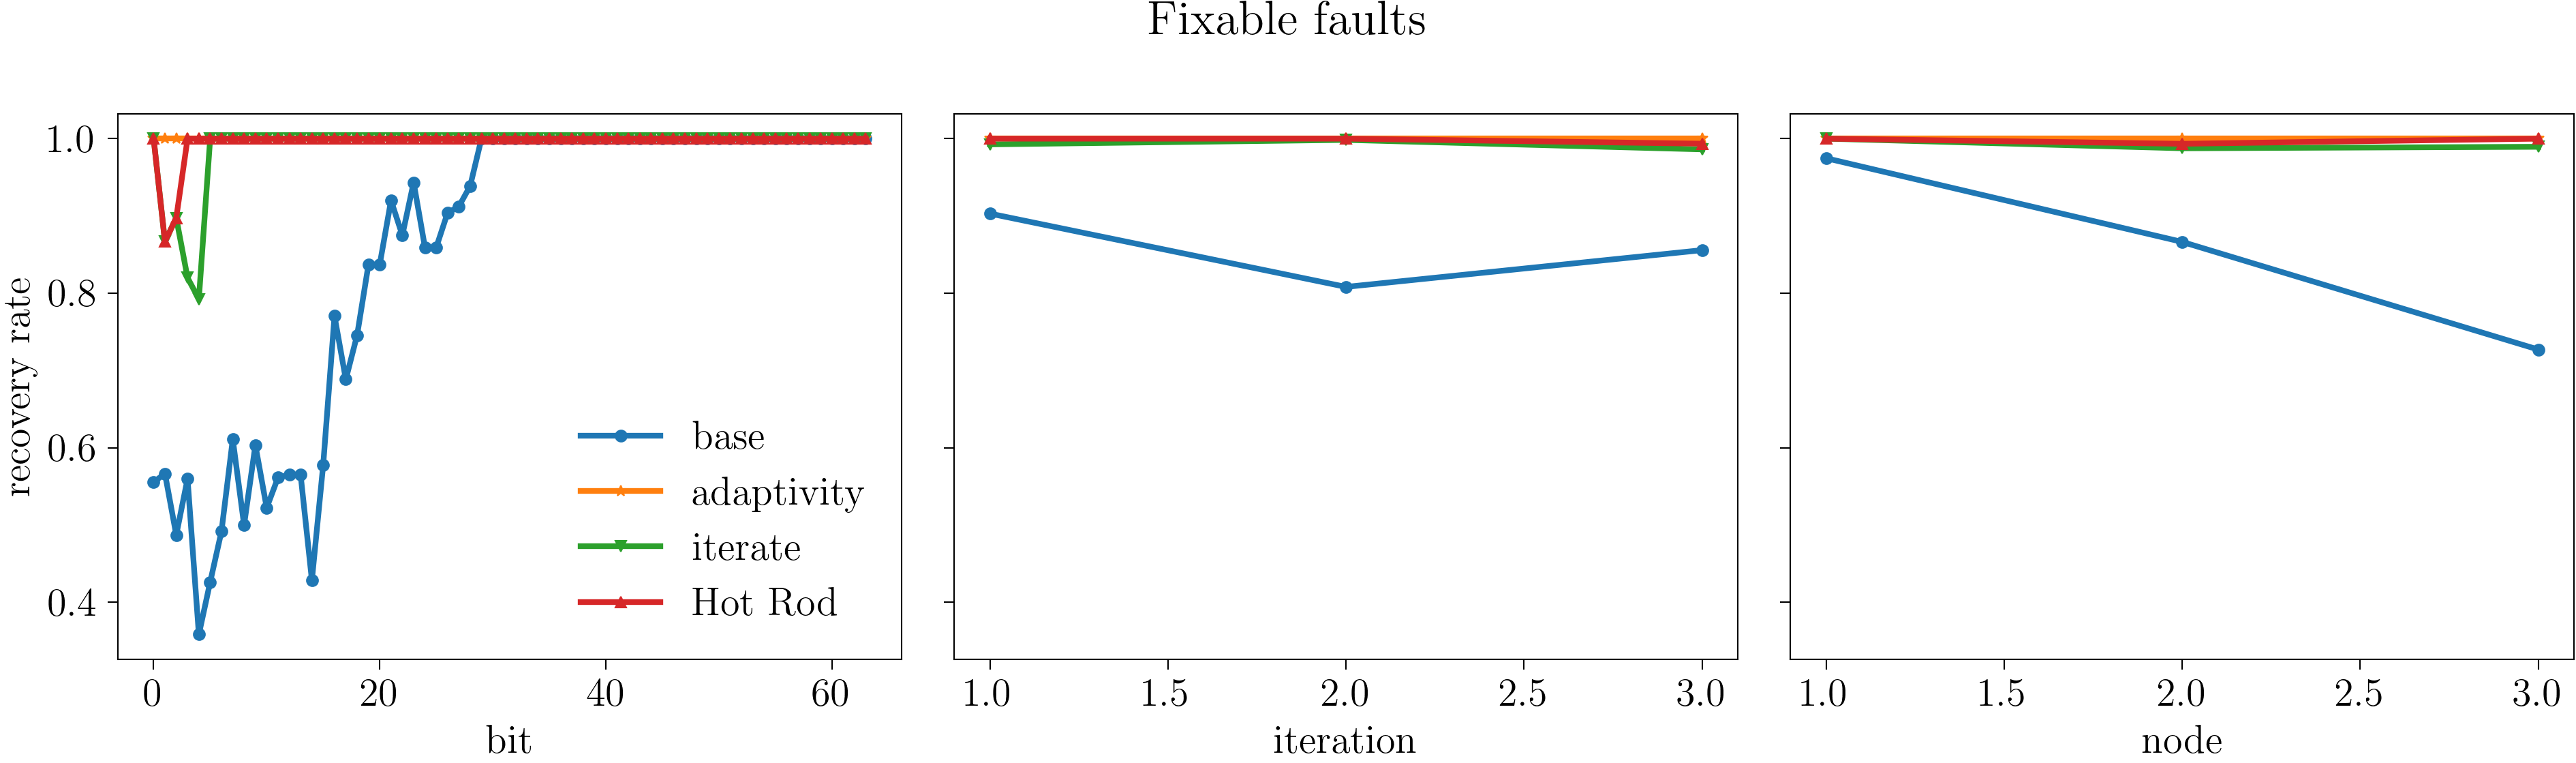

In [7]:
not_crashed = vdp_stats.get_mask(key='error', op='uneq', val=np.inf)
fixable = vdp_stats.get_mask(key='node', op='gt', val=0, old_mask=not_crashed)

plot_stuff(vdp_stats, op=vdp_stats.rec_rate, ylabel='recovery rate', mask=fixable, suptitle='Fixable faults')

Now, we can see much larger differences in the resilience capabilities of the strategies and we see that the purely iteration based scheme struggles with faults in later iterations or collocation nodes.
This makes sense since we allow only up to 99 iterations before we accept the step regardless of whether the tolerance was reached.
We could, however, devise a potentially rather resilient strategy by restarting the step if we didn't converge within 99 iterations rather than just moving on.
**TODO run more stats and see if this is just coincidence**

We can take this one step further and only look at faults that are dangerous, i.e. not recovered by doing nothing:

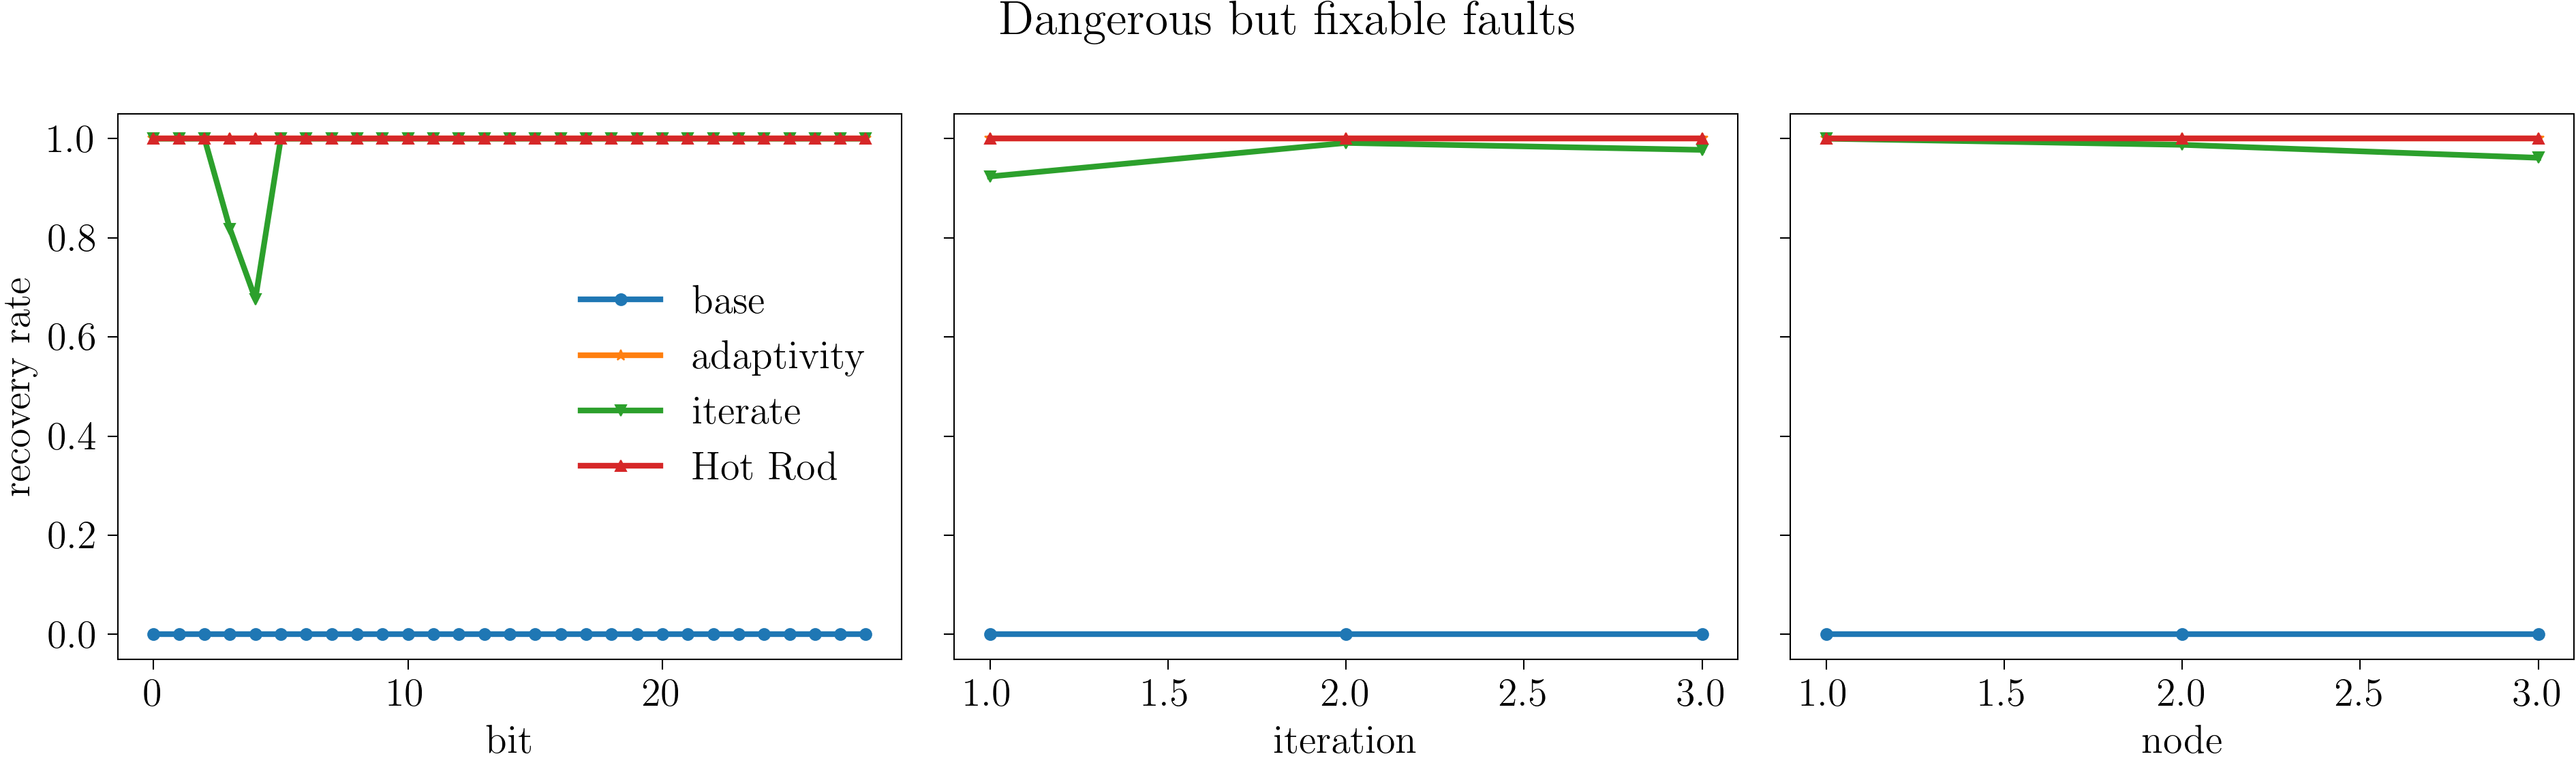

In [8]:
dangerous_but_fixable = vdp_stats.get_mask(key='recovered', op='eq', val=False, old_mask=fixable)

plot_stuff(vdp_stats, op=vdp_stats.rec_rate, ylabel='recovery rate', mask=dangerous_but_fixable,
           suptitle='Dangerous but fixable faults')

Adaptivity and Hot Rod are both very efficient in fixing these faults, but adaptive iteration counts are struggling with these faults.

## Efficiency of the different strategies
A perfect resilience strategy is no use if it gives too much overhead.
After all, we started on the premise that we can get perfect resilience by replicating the solution suficiently many times, but we find that too expensive in energy cost and either time of hardware cost.

So it is imperative to consider what overhead we introduce in two places.
First of all, we change the scheme considerably by varying iteration and step sizes, which changes the efficiency when no faults are involved.
Second, we also want to know how much overhead is introduced by recovering a fault on top of the overhead that we get from looking out for faults.

We already discussed the efficiency in the absense of faults [here](#efficiency) and learned that adaptively choosing $k$ or $\Delta t$ leads to fewer iterations required to reach the same accuracy.
Now let's plot how many more iterations we do on average when we flip a particular bit.
We again look only at the dangerous but fixable faults because when the faults are not fixable, we don't care how expensive the scheme is, we just get rubbish and the non-dangerous faults should not incur any overhead.

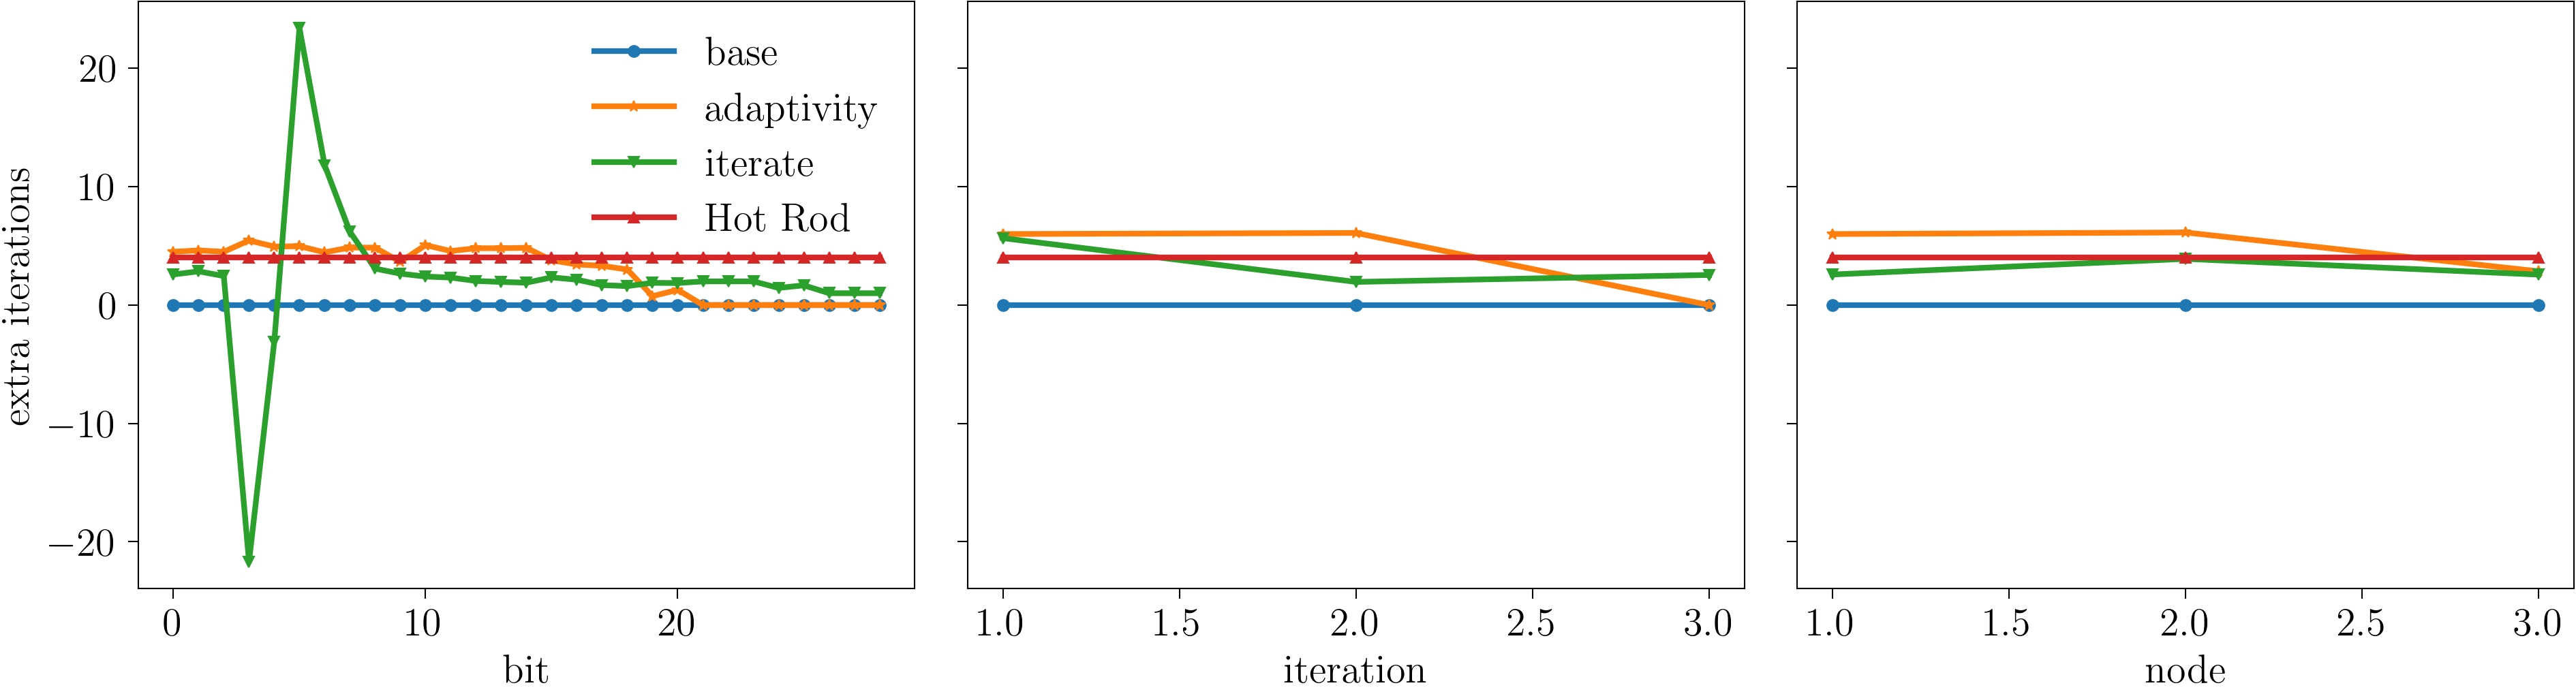

In [9]:
plot_stuff(vdp_stats, op=vdp_stats.extra_mean, ylabel='extra iterations', mask=dangerous_but_fixable,
           thingA='total_iteration')

What we see is mostly what we expected: 
 - The base scheme does not care about faults and will not do any extra iterations
 - Hot Rod will always do one extra step to restart the faulty step
 - Allowing adaptive $k$ or $\Delta t$ leads to slighlty unpredictable behaviour

Adaptivity apparently performs a few extra steps for most large faults, while performing no extra iterations for smaller faults.
Adaptive iteration counts on the other hand perform the same amount of steps, since restarts are not allowed, but the iteration count required to fix the fault can be quite high.
In some cases the fault is not fixed after the maximum allowed iteration count of 99 and we solve a very different problem, which sometimes needs fewer iterations to solve.

## Conclusions
We inserted random faults in the van der Pol problem 